In [6]:
import pandas as pd
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

col_names = ["session","date","level","code","server_error","client_error","version","submission_id","lang", "email", "username", "demo","start"]
df = pd.read_csv("../../Data/2-logs-plain-2.csv", names=col_names)
df = df.iloc[1:]

#Keep all code resulting in an error and that does not contain the start or demo programs
df = df.loc[df['demo'] != True]
df = df.loc[df['start'] != True]
df = df.loc[df['server_error'] != "None"]
df = df.loc[df['server_error'] != "-"]
df['date'] = pd.to_datetime(df['date'], format="%Y-%m-%d %H:%M:%S.%f")

/Library/Frameworks/Python.framework/Versions/3.8/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3145: DtypeWarning: Columns (3,12,13) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


## Explanatory Notes

From here on it gets complicated. The goal is to get the error code for each session (user) sorted by level. Then we want to look at errors following directly unto each other and calculate the time between these errors messages. Concluding the amount of time the users took to debug the code and run again. Note: This is different then the identical code analysis! In that case we already know that the students did not bother to change the code, now we are interested in when they did.

In [7]:
#Change of plans: Of course if there is a succesfull code run in between, this one shouldn't count!
#Therefore, we should be merging all the data with the 

temp_df = df.groupby(['session', 'level']).size().to_frame('size')
total = pd.merge(df, temp_df, left_on=['session','level'], right_on = ['session','level'])
total = total.loc[total['size'] > 1] #There are multiple (error) registrations for this session in the level
total = total.sort_values(by=['session', 'level', 'date'], ascending=[True, True, True])

print(total)

#The dataset containing everything to merge with the one keeping track of amount of mistakes
#If there is a non-error submission within a level between two error onces it should be deleted
#df = pd.read_csv("../../Data/2-logs-plain-0902.csv", names=col_names)
#df = df.iloc[1:]
#df = df.loc[df['demo'] != True]
#df = df.loc[df['start'] != True]

                                 session                       date level  \
152883  0002e754cb9f4d7db498006bbe739b23 2021-04-23 12:24:48.869756     1   
152882  0002e754cb9f4d7db498006bbe739b23 2021-04-23 12:31:09.835129     1   
226322  00042b2a9cd44ba7bad76020efbfa6bf 2021-05-24 11:05:07.589254     8   
226321  00042b2a9cd44ba7bad76020efbfa6bf 2021-05-24 11:09:55.397825     8   
226320  00042b2a9cd44ba7bad76020efbfa6bf 2021-05-24 11:17:23.846449     8   
...                                  ...                        ...   ...   
21576   fffbf5b2a6d243dc87503b8aa99268e6 2020-12-08 09:30:39.226936     4   
21575   fffbf5b2a6d243dc87503b8aa99268e6 2020-12-08 09:32:04.175814     4   
21574   fffbf5b2a6d243dc87503b8aa99268e6 2020-12-08 09:32:12.629509     4   
85440   fffe40253b164c80ad6db20026c719c0 2021-03-09 08:31:57.609514     7   
85441   fffe40253b164c80ad6db20026c719c0 2021-03-09 08:32:00.767241     7   

                                                     code  \
152883        

In [11]:
import numpy as np
import datetime

multipleErrors = df.groupby(['session', 'code']).size().to_frame('size')
multipleErrors2 = multipleErrors.loc[multipleErrors['size'] == 2]
multipleErrors3 = multipleErrors.loc[multipleErrors['size'] == 3]

total = pd.merge(df, multipleErrors2, left_on=['session','code'], right_on = ['session','code'])
total2 = total.loc[total['size'] == 2]
total2 = total.sort_values(by=['session', 'date'], ascending=[True, True])
timeDifferences = []
i = 0
temp = None

for index, row in total2.iterrows():
    if i % 2 == 0:
        temp = row['date']
    else:
        timeDifferences.append(row['date'] - temp)     
    i += 1

timeFrame = pd.DataFrame(timeDifferences, columns =['time'])
print("Total amount of identical (two-time) submission time: " + str(timeFrame.shape[0]))
timeFrame['new'] = timeFrame['time'].values.astype(np.int64)
mean = timeFrame['new'].mean()
std = timeFrame['new'].std()

Total amount of identical (two-time) submission time: 24926
Total amount of very fast re-submission (within 1 second): 4373
Total amount of very fast re-submission (within 3 seconds): 7999
Total amount of very fast re-submission (within 5 seconds): 9388
Total amount of very fast re-submission (within 10 seconds): 12301


In [51]:
#New idea: get the amount of time between two submissions
from tqdm.notebook import tqdm

data = []

for i in range(1, 31):
    data.append(timeFrame.loc[timeFrame['time'] < datetime.timedelta(seconds=i+1)].shape[0])
    
dict_data = {}
    
for i in range(0, len(data)-1):
    dict_data[i] = data[i+1] - data[i]
    
print(dict_data)   

{0: 932, 1: 752, 2: 637, 3: 657, 4: 610, 5: 581, 6: 540, 7: 525, 8: 476, 9: 480, 10: 482, 11: 432, 12: 401, 13: 385, 14: 354, 15: 334, 16: 296, 17: 304, 18: 321, 19: 280, 20: 268, 21: 230, 22: 247, 23: 254, 24: 223, 25: 215, 26: 202, 27: 207, 28: 176}


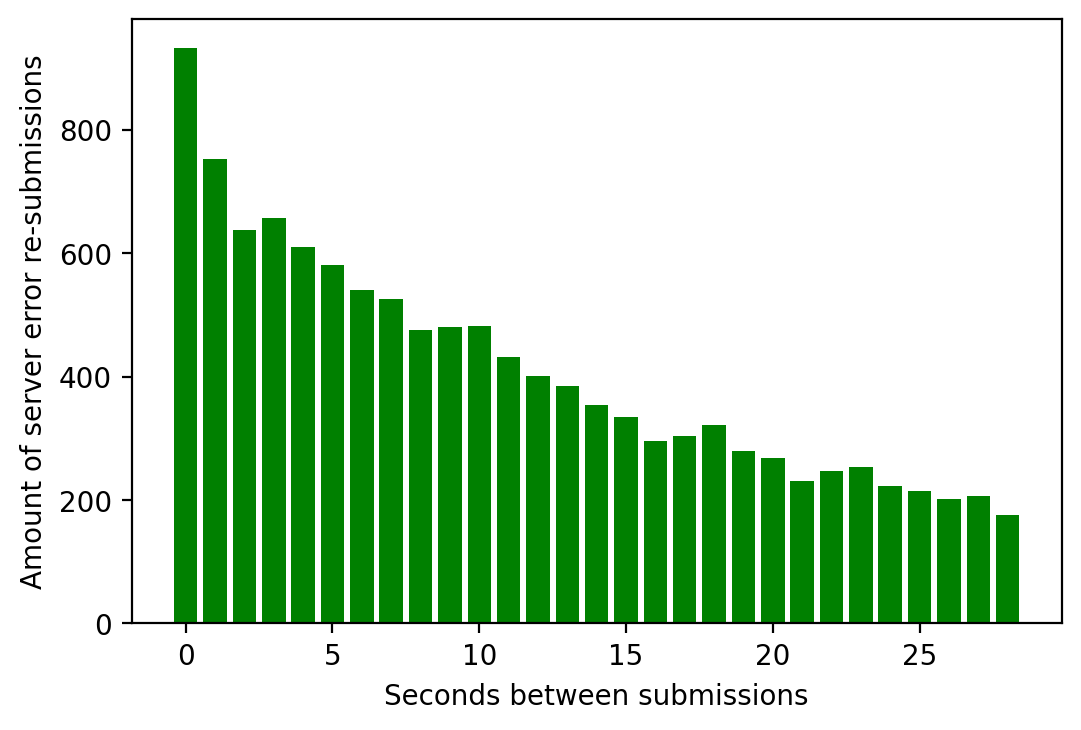

In [52]:
import matplotlib.pylab as plt
plt.rcParams['figure.dpi'] = 200

plt.bar(*zip(*dict_data.items()), color='green')
plt.xlabel("Seconds between submissions")
plt.ylabel("Amount of server error re-submissions")
plt.show()